# Patent analysis on Powertrain technologies
Data collected on multiple powertrain technologies such as electric vehicle, hybrid electric vehicle, fuel cells vehicles and internal combusion engine(traditional vehicles) patent. We have made a text analysis on these technologies and performed topic modeling.

# 1) Importing key modules

In [1]:
# Let's be rebels and ignore warnings for now
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Visualization 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
# For data processing and modeling
import nltk
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [4]:
# For LDA visuals
from __future__ import print_function
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook() 

# 2) Loading data

In [5]:
assignments = pd.read_csv('patent_ev.csv')

In [6]:
assignments.head()

,appln,appln_id,family_id,sets,direct,granted,earliest_appln,earliest_filing_date,publn_date,publn,...,num_citing_publn,citing_publn_date,citing_publn,citing_appln,citing_appln_id,citing_family_id,num_citing_family,earliest_applt,current_applt,appln_title
0,DE69118393A,14285742,1239277,2,0,0,WO9105114W,1991-08-07,1996-05-02,DE69118393D1,...,0,NaN,NaN,NaN,NaN,NaN,30,"ELECTRIC FUEL (E.F.L.) LTD., JERUSALEM, IL","ELECTRIC FUEL (E.F.L.) LTD., JERUSALEM, IL",ELEKTRISCHES ENERGIESYSTEM
1,DE69118393T,14285743,1239277,2,0,1,WO9105114W,1991-08-07,1996-09-05,DE69118393T2,...,2,2016-02-25\n2018-05-22,DE102014216372A1\nUS9975438B2,DE102014216372A\nUS201715436024A,449479509\n479351260,53836089\n53836089,30,"ELECTRIC FUEL (E.F.L.) LTD., JERUSALEM, IL","ELECTRIC FUEL (E.F.L.) LTD., JERUSALEM, IL",ELEKTRISCHES ENERGIESYSTEM
2,EP91915464A,16916549,1239277,2,0,1,WO9105114W,1991-08-07,1993-09-01\n1994-03-09\n1996-03-27,EP0557287A1\nEP0557287A4\nEP0557287B1,...,1,2007-12-25,US7313469B2,US51676105A,51497271,29718835,30,ELECTRIC FUEL (E.F.L.) LTD.,ELECTRIC FUEL (E.F.L.) LTD.,ELECTRICAL ENERGY SYSTEM
3,WO9105114W,47158713,1239277,2,1,1,US55592190A,1990-07-19,1993-02-18,WO9303532A1,...,1,2002-07-11,WO0199222A3,WO0119827W,45621927,24395918,30,LUZ ELECTRIC FUEL ISRAEL LTD.,LUZ ELECTRIC FUEL ISRAEL LTD.,ELECTRICAL ENERGY SYSTEM
4,US55592190A,51797454,1239277,2,1,1,US55592190A,1990-07-19,1992-06-09,US5121044A,...,44,1993-05-04\n1994-03-09\n1994-09-20\n1995-07-18...,US5208526A\nEP0557287A4\nUS5349535A\nUS5434020...,US63645090A\nEP91915464A\nUS96399792A\nUS15296...,52393850\n16916549\n54353461\n48212422\n457802...,27071024\n1239277\n25508001\n22545199\n2636904...,30,"Luz Electric Fuel Israel, Ltd.","Luz Electric Fuel Israel, Ltd.",Electrical energy system


In [7]:
assignments['granted'].value_counts()

1    16981
0     6851
Name: granted, dtype: int64

1    16981
0     6851
Name: granted, dtype: int64


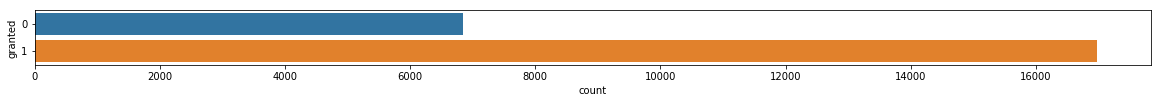

In [8]:
fig = plt.figure(figsize=(20,1))
sns.countplot(y='granted', data=assignments);
print(assignments.granted.value_counts())

In [9]:
assignments.shape

(23832, 32)

In [10]:
patent=assignments['appln_title']

In [11]:
patent[:3]

0    ELEKTRISCHES ENERGIESYSTEM
1    ELEKTRISCHES ENERGIESYSTEM
2      ELECTRICAL ENERGY SYSTEM
Name: appln_title, dtype: object

**Need full abstract or atleast full title of given patent**

## a) Types of features in our dataset

In [12]:
assignments.dtypes.value_counts()

object    21
int64     11
dtype: int64

In [13]:
# Checking all variables with their data-type
def _tbl_dtype(dataset):
    sum_dtype = pd.DataFrame(dataset.dtypes).sort_values(0).rename(columns = {0:'Data Type'})
    return sum_dtype

table_dtype = _tbl_dtype(assignments)
table_dtype

,Data Type
num_cited_publn,int64
appln_id,int64
family_id,int64
sets,int64
direct,int64
granted,int64
num_cited_family,int64
num_citing_family,int64
num_citing_publn,int64
num_ipc_class,int64


## b) Checking missing values

In [14]:
def find_missing_values(df, columns):
    """
    Finds number of rows where certain columns are missing values.
    ::param_df:: = target dataframe
    ::param_columns:: = list of columns
    """
    missing_vals = {}
    print("Number of missing or NaN values for each column:")
    df_length = len(df)
    for column in columns:
        total_column_values = df[column].value_counts().sum()
        missing_vals[column] = df_length-total_column_values
        #missing_vals.append(str(column)+ " column has {} missing or NaN values.".format())
    return missing_vals

In [15]:
missing_values = find_missing_values(assignments, columns=assignments.columns)
missing_values

Number of missing or NaN values for each column:


{'appln': 0,
 'appln_id': 0,
 'family_id': 0,
 'sets': 0,
 'direct': 0,
 'granted': 0,
 'earliest_appln': 0,
 'earliest_filing_date': 0,
 'publn_date': 0,
 'publn': 0,
 'publn_first_grant': 0,
 'num_cpc_class': 0,
 'cpc_class': 1624,
 'num_ipc_class': 0,
 'ipc_class': 85,
 'num_cited_publn': 0,
 'cited_publn_date': 9456,
 'cited_publn': 9456,
 'cited_appln': 9456,
 'cited_appln_id': 9456,
 'cited_family_id': 9456,
 'num_cited_family': 0,
 'num_citing_publn': 0,
 'citing_publn_date': 10499,
 'citing_publn': 10499,
 'citing_appln': 10499,
 'citing_appln_id': 10499,
 'citing_family_id': 10499,
 'num_citing_family': 0,
 'earliest_applt': 843,
 'current_applt': 843,
 'appln_title': 0}

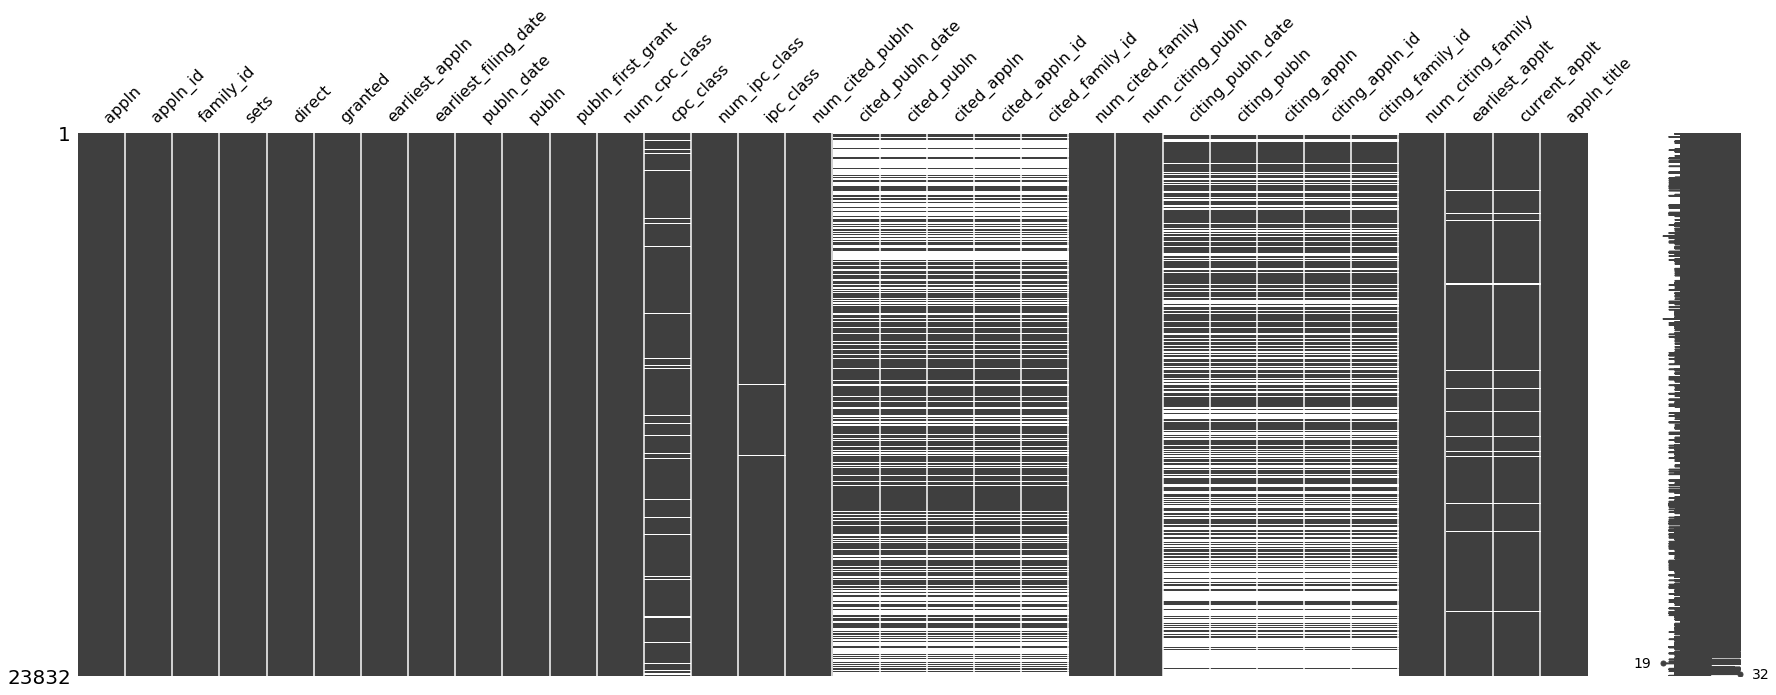

In [16]:
import missingno
missingno.matrix(assignments, figsize = (30,10))

In [17]:
def summary_missing(dataset):
    n_miss = dataset.isnull().sum()
    n_obs = dataset.shape[0]
    n_miss_per = n_miss/n_obs*100
    n_miss_tbl = pd.concat([n_miss, n_miss_per], axis = 1).sort_values(1, ascending = False).round(1)
    n_miss_tbl = n_miss_tbl[n_miss_tbl[1] != 0]
    print('No. of fields: ', dataset.shape[0])
    print('No. of missing fields: ', n_miss_tbl.shape[0])
    n_miss_tbl = n_miss_tbl.rename(columns = {0:'No. of mising Value', 1:'%age of missing Value'})
    return n_miss_tbl

summary_missing(assignments)

No. of fields:  23832
No. of missing fields:  14


,No. of mising Value,%age of missing Value
citing_publn,10499,44.1
citing_publn_date,10499,44.1
citing_family_id,10499,44.1
citing_appln_id,10499,44.1
citing_appln,10499,44.1
cited_publn,9456,39.7
cited_appln_id,9456,39.7
cited_family_id,9456,39.7
cited_publn_date,9456,39.7
cited_appln,9456,39.7


## c) Checking data for text analysis

In [18]:
chars = list(set(patent)) 
data_size, vocab_size = len(patent), len(chars)
print ("Patent data has chars", data_size)
print ("Patent data has unique chars", vocab_size)

Patent data has chars 23832
Patent data has unique chars 16419


**We do not have have a higher difference in unique words and total chars. That's why we need abstract or atleast full title**

### Creating a dataframe for data exploring


In [19]:
data_text = assignments[['appln_title']]

In [20]:
type(data_text)

pandas.core.frame.DataFrame

In [21]:
data_text[:5]

,appln_title
0,ELEKTRISCHES ENERGIESYSTEM
1,ELEKTRISCHES ENERGIESYSTEM
2,ELECTRICAL ENERGY SYSTEM
3,ELECTRICAL ENERGY SYSTEM
4,Electrical energy system


In [22]:
data_text['index'] = data_text.index
documents = data_text

In [23]:
documents.head()

,appln_title,index
0,ELEKTRISCHES ENERGIESYSTEM,0
1,ELEKTRISCHES ENERGIESYSTEM,1
2,ELECTRICAL ENERGY SYSTEM,2
3,ELECTRICAL ENERGY SYSTEM,3
4,Electrical energy system,4


In [24]:
print(len(documents))

23832


In [29]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')

import nltk
import gensim

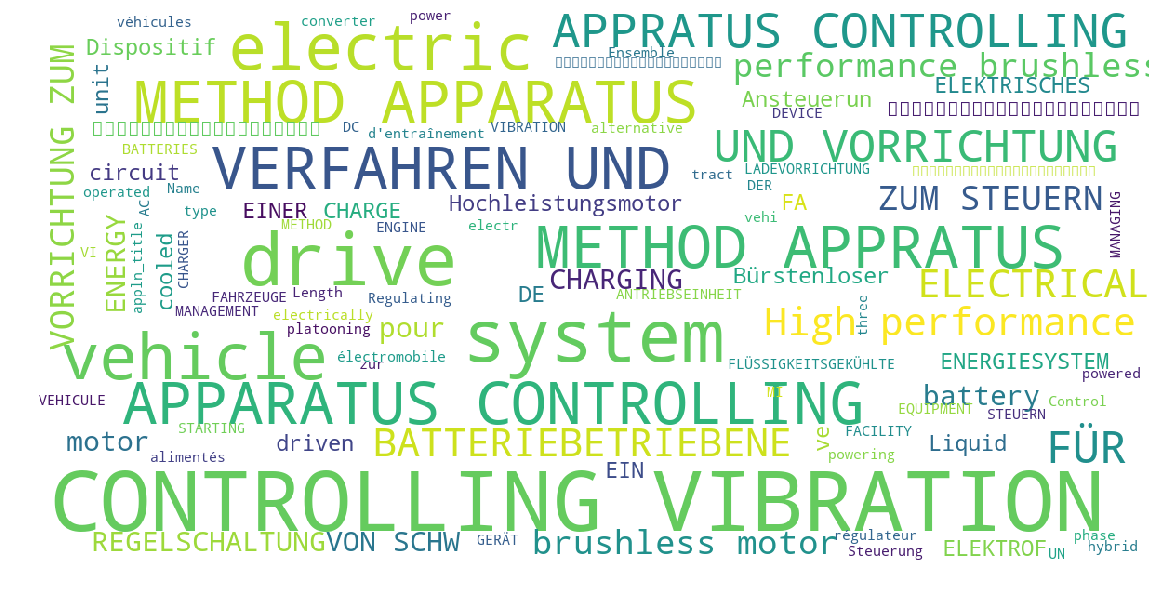

In [26]:
from wordcloud import WordCloud, STOPWORDS
stopwords=set(STOPWORDS)

def Mywordcloud (data, title=None):
    wordcloud=WordCloud(
    background_color='white',
    stopwords=stopwords,
    max_words= 100 ,
    max_font_size=40 ,
    scale=3,
    random_state=1
    ).generate(str(data))
    
    fig=plt.figure(1 , figsize(20, 20))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)
    
    plt.imshow(wordcloud)
    plt.show()
Mywordcloud(documents['appln_title'].dropna())

# 3) Cleaning + document-term matrix conversion

In [30]:
docs_raw = documents['appln_title']

In [31]:
# 1st is countvector
tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.5, 
                                min_df = 10)
dtm_tf = tf_vectorizer.fit_transform(docs_raw) # document-term matrix
print(dtm_tf.shape)

(23832, 1020)


**Same approach for TFIDF**

In [32]:
# 1st is countvector
tfidf_vectorizer = TfidfVectorizer(**tf_vectorizer.get_params())
# document-term matrix
dtm_tfidf = tfidf_vectorizer.fit_transform(docs_raw)
print(dtm_tfidf.shape)

(23832, 1020)


# 4) Latent Dirichlet Allocation models

In [38]:
# for TF DTM
lda_tf = LatentDirichletAllocation(n_components=20, random_state=0, learning_method= "batch")
lda_tf.fit(dtm_tf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=20, n_jobs=1, n_topics=None, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [39]:
# for TFIDF DTM
lda_tfidf = LatentDirichletAllocation(n_components=20, random_state=0, learning_method= "batch")
lda_tfidf.fit(dtm_tfidf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=20, n_jobs=1, n_topics=None, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

# 5) Visualizing the models with pyLDAvis

In [40]:
pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
17    -0.034349  0.012719       1        1  7.849546
7     -0.272112 -0.025208       2        1  7.261310
2     -0.256983 -0.132736       3        1  6.427804
12     0.161084 -0.145298       4        1  6.029923
18     0.075462  0.010409       5        1  5.895844
19     0.205145 -0.054185       6        1  5.584496
1     -0.004955  0.337608       7        1  5.468190
0      0.019618  0.216420       8        1  5.278127
5      0.068420 -0.015422       9        1  5.219073
6      0.193656 -0.043294      10        1  4.997598
9     -0.141985 -0.074168      11        1  4.686516
11    -0.235672 -0.079839      12        1  4.680541
10    -0.032628 -0.004238      13        1  4.624395
15     0.155580 -0.053468      14        1  4.389338
14    -0.054221 -0.119304      15        1  4.281083
4     -0.080305  0.017822      16        1  4.084293
3     -0.022977  0.310558      17        1  3.616797
13     0.101011 -0.067072      18        1  3.294065
8      0.016918 -0.004032      19        1  3.170545
16     0.139295 -0.087270      20        1  3.160516, topic_info=     Category         Freq              Term        Total  loglift  logprob
term                                                                       
198   Default  3916.000000           control  3916.000000  30.0000  30.0000
146   Default  3909.000000          charging  3909.000000  29.0000  29.0000
695   Default  3826.000000             power  3826.000000  28.0000  28.0000
452   Default  3062.000000            hybrid  3062.000000  27.0000  27.0000
46    Default  2078.000000         apparatus  2078.000000  26.0000  26.0000
605   Default  1644.000000             motor  1644.000000  25.0000  25.0000
94    Default  3313.000000           battery  3313.000000  24.0000  24.0000
76    Default  1824.000000        automobile  1824.000000  23.0000  23.0000
985   Default  1321.000000          vehicles  1321.000000  22.0000  22.0000
203   Default  1146.000000       controlling  1146.000000  21.0000  21.0000
125   Default  1044.000000               car  1044.000000  20.0000  20.0000
202   Default   855.000000        controller   855.000000  19.0000  19.0000
581   Default  5629.000000            method  5629.000000  18.0000  18.0000
913   Default  1010.000000            supply  1010.000000  17.0000  17.0000
560   Default   797.000000        management   797.000000  16.0000  16.0000
141   Default   802.000000            charge   802.000000  15.0000  15.0000
279   Default   964.000000             drive   964.000000  14.0000  14.0000
349   Default  1198.000000            energy  1198.000000  13.0000  13.0000
284   Default   664.000000           driving   664.000000  12.0000  12.0000
934   Default   632.000000           thereof   632.000000  11.0000  11.0000
249   Default  4140.000000            device  4140.000000  10.0000  10.0000
908   Default   659.000000         structure   659.000000   9.0000   9.0000
965   Default   477.000000              type   477.000000   8.0000   8.0000
414   Default   577.000000               fur   577.000000   7.0000   7.0000
900   Default   672.000000           storage   672.000000   6.0000   6.0000
143   Default   478.000000           charger   478.000000   5.0000   5.0000
998   Default   561.000000           voltage   561.000000   4.0000   4.0000
304   Default   437.000000      electrically   437.000000   3.0000   3.0000
211   Default   392.000000           cooling   392.000000   2.0000   2.0000
969   Default   473.000000               und   473.000000   1.0000   1.0000
...       ...          ...               ...          ...      ...      ...
702   Topic20    49.150522        prediction    50.102800   3.4352  -4.1746
580   Topic20    44.687364          metering    45.639642   3.4333  -4.2698
854   Topic20    43.571575             small    44.523853   3.4328  -4.2951
435   Topic20    79.299152              heat    81.2029

### With TF-IDF

In [41]:
pyLDAvis.sklearn.prepare(lda_tfidf, dtm_tfidf, tfidf_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
7      0.102755  0.235025       1        1  6.574541
2      0.082980  0.158768       2        1  6.419805
19     0.019534 -0.060508       3        1  6.358482
18     0.042831 -0.218823       4        1  6.251285
3      0.075716 -0.037184       5        1  5.902454
17     0.064872 -0.161462       6        1  5.841359
12    -0.465019  0.039036       7        1  5.293056
11     0.080421  0.149443       8        1  5.146007
6      0.045564 -0.013849       9        1  4.859563
10     0.048643 -0.083930      10        1  4.732688
9      0.091963  0.038838      11        1  4.726653
16     0.014359 -0.046497      12        1  4.647076
1      0.062554  0.098636      13        1  4.600398
5      0.010803 -0.007251      14        1  4.505965
15     0.034679  0.033619      15        1  4.487727
4      0.040980  0.066077      16        1  4.297909
14     0.055768 -0.110029      17        1  4.149618
0     -0.229417  0.114003      18        1  4.114688
8      0.005905 -0.100412      19        1  3.764916
13    -0.185892 -0.093500      20        1  3.325811, topic_info=     Category         Freq           Term        Total  loglift  logprob
term                                                                    
202   Default   496.000000     controller   496.000000  30.0000  30.0000
913   Default   458.000000         supply   458.000000  29.0000  29.0000
146   Default  1274.000000       charging  1274.000000  28.0000  28.0000
198   Default  1311.000000        control  1311.000000  27.0000  27.0000
143   Default   275.000000        charger   275.000000  26.0000  26.0000
203   Default   480.000000    controlling   480.000000  25.0000  25.0000
284   Default   301.000000        driving   301.000000  24.0000  24.0000
695   Default  1094.000000          power  1094.000000  23.0000  23.0000
934   Default   293.000000        thereof   293.000000  22.0000  22.0000
279   Default   419.000000          drive   419.000000  21.0000  21.0000
76    Default   735.000000     automobile   735.000000  20.0000  20.0000
414   Default   235.000000            fur   235.000000  19.0000  19.0000
452   Default  1038.000000         hybrid  1038.000000  18.0000  18.0000
281   Default   185.000000         driven   185.000000  17.0000  17.0000
696   Default   172.000000        powered   172.000000  16.0000  16.0000
304   Default   192.000000   electrically   192.000000  15.0000  15.0000
965   Default   215.000000           type   215.000000  14.0000  14.0000
560   Default   326.000000     management   326.000000  13.0000  13.0000
605   Default   606.000000          motor   606.000000  12.0000  12.0000
880   Default   225.000000        station   225.000000  11.0000  11.0000
652   Default   182.000000           pack   182.000000  10.0000  10.0000
985   Default   492.000000       vehicles   492.000000   9.0000   9.0000
211   Default   177.000000        cooling   177.000000   8.0000   8.0000
900   Default   238.000000        storage   238.000000   7.0000   7.0000
349   Default   374.000000         energy   374.000000   6.0000   6.0000
249   Default  1231.000000         device  1231.000000   5.0000   5.0000
969   Default   172.000000            und   172.000000   4.0000   4.0000
60    Default   153.000000       assembly   153.000000   3.0000   3.0000
350   Default   172.000000         engine   172.000000   2.0000   2.0000
188   Default   138.000000      connector   138.000000   1.0000   1.0000
...       ...          ...            ...          ...      ...      ...
484   Topic20     9.703696          inlet    10.643096   3.3111  -4.9764
515   Topic20     9.545342      ladegerat    10.484742   3.3096  -4.9928
288   Topic20     9.203747         dynamo    10.143147   3.3063  -5.0293
404   Topic20     9.035077          forms     9.974477   3.3045  -5.0478
98    Topic20     8.769115    betriebenes     9.708515   3.3017  -5.0776
616   Topic20    

### Using different MDS functions

- mds :function or a string representation of function

A function that takes topic_term_dists as an input and outputs a n_topics by 2 distance matrix. The output approximates the distance between topics. See js_PCoA() for details on the default function. A string representation currently accepts pcoa (or upper case variant), mmds (or upper case variant) and tsne (or upper case variant), if sklearn package is installed for the latter two.

In [42]:
pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer, mds='mmds')

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
17    -0.178458  0.184916       1        1  7.849546
7      0.138783 -0.053469       2        1  7.261310
2      0.278200 -0.147877       3        1  6.427804
12    -0.505539 -0.235062       4        1  6.029923
18    -0.431707  0.170957       5        1  5.895844
19    -0.087080  0.466790       6        1  5.584496
1      0.325770  0.309888       7        1  5.468190
0      0.051677  0.303733       8        1  5.278127
5      0.450547 -0.181232       9        1  5.219073
6     -0.280251  0.379268      10        1  4.997598
9     -0.056754 -0.030514      11        1  4.686516
11     0.407509  0.023288      12        1  4.680541
10    -0.322328  0.001768      13        1  4.624395
15     0.084906 -0.461848      14        1  4.389338
14     0.227979 -0.332610      15        1  4.281083
4      0.232773  0.141896      16        1  4.084293
3      0.214438  0.371443      17        1  3.616797
13    -0.067118 -0.299996      18        1  3.294065
8     -0.261120 -0.155967      19        1  3.170545
16    -0.222226 -0.455373      20        1  3.160516, topic_info=     Category         Freq              Term        Total  loglift  logprob
term                                                                       
198   Default  3916.000000           control  3916.000000  30.0000  30.0000
146   Default  3909.000000          charging  3909.000000  29.0000  29.0000
695   Default  3826.000000             power  3826.000000  28.0000  28.0000
452   Default  3062.000000            hybrid  3062.000000  27.0000  27.0000
46    Default  2078.000000         apparatus  2078.000000  26.0000  26.0000
605   Default  1644.000000             motor  1644.000000  25.0000  25.0000
94    Default  3313.000000           battery  3313.000000  24.0000  24.0000
76    Default  1824.000000        automobile  1824.000000  23.0000  23.0000
985   Default  1321.000000          vehicles  1321.000000  22.0000  22.0000
203   Default  1146.000000       controlling  1146.000000  21.0000  21.0000
125   Default  1044.000000               car  1044.000000  20.0000  20.0000
202   Default   855.000000        controller   855.000000  19.0000  19.0000
581   Default  5629.000000            method  5629.000000  18.0000  18.0000
913   Default  1010.000000            supply  1010.000000  17.0000  17.0000
560   Default   797.000000        management   797.000000  16.0000  16.0000
141   Default   802.000000            charge   802.000000  15.0000  15.0000
279   Default   964.000000             drive   964.000000  14.0000  14.0000
349   Default  1198.000000            energy  1198.000000  13.0000  13.0000
284   Default   664.000000           driving   664.000000  12.0000  12.0000
934   Default   632.000000           thereof   632.000000  11.0000  11.0000
249   Default  4140.000000            device  4140.000000  10.0000  10.0000
908   Default   659.000000         structure   659.000000   9.0000   9.0000
965   Default   477.000000              type   477.000000   8.0000   8.0000
414   Default   577.000000               fur   577.000000   7.0000   7.0000
900   Default   672.000000           storage   672.000000   6.0000   6.0000
143   Default   478.000000           charger   478.000000   5.0000   5.0000
998   Default   561.000000           voltage   561.000000   4.0000   4.0000
304   Default   437.000000      electrically   437.000000   3.0000   3.0000
211   Default   392.000000           cooling   392.000000   2.0000   2.0000
969   Default   473.000000               und   473.000000   1.0000   1.0000
...       ...          ...               ...          ...      ...      ...
702   Topic20    49.150522        prediction    50.102800   3.4352  -4.1746
580   Topic20    44.687364          metering    45.639642   3.4333  -4.2698
854   Topic20    43.571575             small    44.523853   3.4328  -4.2951
435   Topic20    79.299152              heat    81.2029

## tsne option

In [43]:
pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer, mds='tsne')

PreparedData(topic_coordinates=                x           y  topics  cluster      Freq
topic                                                   
17     -33.313820   53.873569       1        1  7.849546
7       26.098303   39.577705       2        1  7.261310
2       56.751518  -72.505386       3        1  6.427804
12      20.029383 -138.149017       4        1  6.029923
18     -58.299305  112.857452       5        1  5.895844
19     -64.482811  -53.371929       6        1  5.584496
1      -81.947021    9.952412       7        1  5.468190
0      -25.437225   -6.558306       8        1  5.278127
5       76.676376    1.641047       9        1  5.219073
6     -116.477989   63.211143      10        1  4.997598
9       81.147469   79.095161      11        1  4.686516
11      93.825241 -124.609512      12        1  4.680541
10    -113.572601  -95.709831      13        1  4.624395
15     122.106270  -50.136322      14        1  4.389338
14     135.141754   27.582275      15        1  4.281083
4      -49.808582 -129.501022      16        1  4.084293
3       -7.815148  -75.409897      17        1  3.616797
13    -137.123444  -23.822054      18        1  3.294065
8       16.277809  108.442543      19        1  3.170545
16      25.697577  -23.886253      20        1  3.160516, topic_info=     Category         Freq              Term        Total  loglift  logprob
term                                                                       
198   Default  3916.000000           control  3916.000000  30.0000  30.0000
146   Default  3909.000000          charging  3909.000000  29.0000  29.0000
695   Default  3826.000000             power  3826.000000  28.0000  28.0000
452   Default  3062.000000            hybrid  3062.000000  27.0000  27.0000
46    Default  2078.000000         apparatus  2078.000000  26.0000  26.0000
605   Default  1644.000000             motor  1644.000000  25.0000  25.0000
94    Default  3313.000000           battery  3313.000000  24.0000  24.0000
76    Default  1824.000000        automobile  1824.000000  23.0000  23.0000
985   Default  1321.000000          vehicles  1321.000000  22.0000  22.0000
203   Default  1146.000000       controlling  1146.000000  21.0000  21.0000
125   Default  1044.000000               car  1044.000000  20.0000  20.0000
202   Default   855.000000        controller   855.000000  19.0000  19.0000
581   Default  5629.000000            method  5629.000000  18.0000  18.0000
913   Default  1010.000000            supply  1010.000000  17.0000  17.0000
560   Default   797.000000        management   797.000000  16.0000  16.0000
141   Default   802.000000            charge   802.000000  15.0000  15.0000
279   Default   964.000000             drive   964.000000  14.0000  14.0000
349   Default  1198.000000            energy  1198.000000  13.0000  13.0000
284   Default   664.000000           driving   664.000000  12.0000  12.0000
934   Default   632.000000           thereof   632.000000  11.0000  11.0000
249   Default  4140.000000            device  4140.000000  10.0000  10.0000
908   Default   659.000000         structure   659.000000   9.0000   9.0000
965   Default   477.000000              type   477.000000   8.0000   8.0000
414   Default   577.000000               fur   577.000000   7.0000   7.0000
900   Default   672.000000           storage   672.000000   6.0000   6.0000
143   Default   478.000000           charger   478.000000   5.0000   5.0000
998   Default   561.000000           voltage   561.000000   4.0000   4.0000
304   Default   437.000000      electrically   437.000000   3.0000   3.0000
211   Default   392.000000           cooling   392.000000   2.0000   2.0000
969   Default   473.000000               und   473.000000   1.0000   1.0000
...       ...          ...               ...          ...      ...      ...
702   Topic20    49.150522        prediction    50.102800   3.4352  -4.1746
580   Topic20    44.687364          metering    45.639642   3.4333  -4.2698
854   Topic20    43.571575             smal

- We can always change value of lumbda
- We can see how frequent some words are used in topic
- It is easy to analyse relation between different topics. Those which are clustered closer mean to have closer relation